In [2]:
#
# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

import os


Using TensorFlow backend.


In [9]:
for file in os.listdir("../EclipseWorkStation/Dataset/IMDB"):
    print(file)

labeledTrainData.tsv.zip
testData.tsv.zip
unlabeledTrainData.tsv.zip


In [10]:
usecols = ['sentiment','review']
train_data = pd.read_csv(
    filepath_or_buffer='../EclipseWorkStation/Dataset/IMDB/labeledTrainData.tsv.zip',
    usecols=usecols, sep='\t')
unlabeled_data = pd.read_csv(
    filepath_or_buffer="../EclipseWorkStation/Dataset/IMDB/unlabeledTrainData.tsv.zip", 
    error_bad_lines=False,
    sep='\t')

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [11]:
datasets = [train_data, unlabeled_data]
titles = ['Train data','Unlabeled train data']
for dataset, title in zip(datasets,titles):
    print(title)
    dataset.info()
    display(dataset.head())


Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
id        49998 non-null object
review    49998 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [12]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 74998


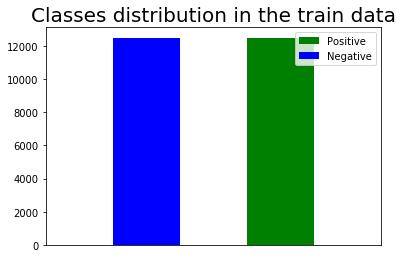

In [14]:
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=20)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [15]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters

def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words

def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [16]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [18]:
import nltk
nltk.download('wordnet')
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TOANDAO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [19]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values

In [20]:
%%time
bigrams = Phrases(sentences=all_reviews)

Wall time: 20.3 s


In [21]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

Wall time: 1min 2s


In [22]:
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [23]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

Wall time: 8min 53s


In [24]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 77482


In [25]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
Wall time: 5min 16s


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [27]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          19835392  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 20,246,145
Trainable params: 410,753
Non-trainable params: 19,835,392
____________________________________

In [28]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)

Train on 23750 samples, validate on 1250 samples
Epoch 1/20
23750/23750 [==============================] - 245s 10ms/step - loss: 0.6776 - accuracy: 0.5796 - val_loss: 0.6355 - val_accuracy: 0.6384
Epoch 2/20
23750/23750 [==============================] - 268s 11ms/step - loss: 0.6128 - accuracy: 0.6729 - val_loss: 0.5640 - val_accuracy: 0.7216
Epoch 3/20
23750/23750 [==============================] - 265s 11ms/step - loss: 0.5359 - accuracy: 0.7389 - val_loss: 0.5323 - val_accuracy: 0.7320
Epoch 4/20
23750/23750 [==============================] - 278s 12ms/step - loss: 0.4829 - accuracy: 0.7749 - val_loss: 0.4449 - val_accuracy: 0.7840
Epoch 5/20
23750/23750 [==============================] - 278s 12ms/step - loss: 0.4431 - accuracy: 0.7962 - val_loss: 0.4225 - val_accuracy: 0.8080
Epoch 6/20
23750/23750 [==============================] - 281s 12ms/step - loss: 0.4023 - accuracy: 0.8189 - val_loss: 0.4675 - val_accuracy: 0.7856
Epoch 7/20
23750/23750 [==============================] -